# Introduction

The following notebook is work-in-progress for the CORD-19-research-challenge on Kaggle.  
Our goal is to be able to search the dataset and find some answers to the tasks that are defined on Kaggle. We are usind mutiple embbeddings such as word2Vec or a simple td-idf on the papers.

## Dataset

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records  

# Setup

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/CORD-19-research-challenge/')

## Install packages 

In [3]:
!pip install mplcursors
!pip install mpld3
!pip install -U sentence-transformers
!pip install mplcursors
!pip install bert-extractive-summarizer
!pip install spacy==2.1.3
!pip install neuralcoref
!python -m spacy download en_core_web_md
!pip install rank_bm25

     |████████████████████████████████| 798kB 42.2MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=652362e4a248ff22dde89cdf5bf20c21d6f0953bfd7a25970a3fd5b78896c63e
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 450kB 20.3MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
     |████████████████████████████████| 1.0MB 40.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.5.1-cp36-none-any.whl size=67076 sha256=c651997127b9f4552be37a7420559b16e69e9fd95cffca1c37d3f7a20e3cb1ae
  Stored in directory: /root/.cache/pip/wheels/22/ca/b4/7ca542b411730a8840f8e090df2ddacffa1c4dd9f209684c19
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=de82703a532f589afe0a0e683bb70d6a4d8700e4bb1e9e1abb318a86

# Import packages

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mplcursors
import json
import os
import glob
import re
import warnings
import random
import spacy
from itertools import chain
import mpld3
from collections import  namedtuple

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from wordcloud import WordCloud

from gensim.models import Word2Vec, Doc2Vec
from gensim.utils import simple_preprocess

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import transformers
from rank_bm25 import BM25Okapi

## Download the stopwords and special characters

In [6]:
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
warnings.filterwarnings(action='once')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data processing

### Collect json files from the attached drive

In [0]:
metadata_df = pd.read_csv('./metadata.csv')  

In [0]:
filepath_biorxiv = './biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = './noncomm_use_subset/noncomm_use_subset'
filepath_comm = './comm_use_subset/comm_use_subset'
filepath_custom = './custom_license/custom_license'

all_json_files = glob.glob(f'**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'custom_license/**/*.json', recursive=True)


# Collect json files from the local machine

In [0]:
# enumerate json files
all_json_files = glob.glob(f'data/**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'data/biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'data/noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'data/comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'data/custom_license/**/*.json', recursive=True)

In [0]:
# get all paths
filepath_biorxiv = '.data/biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = '.data/noncomm_use_subset/noncomm_use_subset'
filepath_comm = './data/comm_use_subset/comm_use_subset'
filepath_custom = '.data/custom_license/custom_license'

In [0]:
metadata_df = pd.read_csv('data/metadata.csv')

### Create dictionary
Create a dictionary with the plain texts, indexing all papers with it's ID, store dictionary as json

In [0]:
# convert metadata_df to numpy array
metadata_np = np.array(metadata_df)

# extract the indecies of important properties
cord_uid_index = metadata_df.columns.get_loc("cord_uid")
sha_index = metadata_df.columns.get_loc("sha")
title_index = metadata_df.columns.get_loc("title")
abstract_index = metadata_df.columns.get_loc("abstract")
authors_index = metadata_df.columns.get_loc("authors")
journal_index = metadata_df.columns.get_loc("journal")
publish_time_index = metadata_df.columns.get_loc("publish_time")
has_pdf_parse_index = metadata_df.columns.get_loc("has_pdf_parse")
full_text_file_index = metadata_df.columns.get_loc("full_text_file")
url_index = metadata_df.columns.get_loc("url")

In [0]:
paper_dict = {}
for i in range(metadata_np.shape[0])[0:1000]:
    # extract body text from json file if possible
    has_pdf_parse = metadata_np[i][has_pdf_parse_index]
    if has_pdf_parse:
        full_text_file = metadata_np[i][full_text_file_index]
        sha = metadata_np[i][sha_index]

        json_file_glob = 'data/{0}/**/{1}.json'.format(full_text_file, sha)
        paper = glob.glob(json_file_glob, recursive=True)
        
        body_text = ''
        try:
            with open(os.path.join(paper[0])) as json_file:
                paper_json = json.load(json_file)
                body_text = concat_json_properties(paper_json['body_text'], 'text')
        except:
            pass
        
    # create dict
    paper_dict[metadata_np[i][cord_uid_index]] = {
        'sha': sha,
        'title': metadata_np[i][title_index],
        'authors': metadata_np[i][authors_index],
        'abstract': metadata_np[i][abstract_index],
        'body_text': body_text,
        'publish_date': metadata_np[i][publish_time_index],
        'journal': metadata_np[i][journal_index],
        'url': metadata_np[i][url_index],
    }

with open('paper_dict.json', 'w') as fw:
    json.dump(paper_dict, fw, indent=2)

Load the dictionary from the json file

In [0]:
paper_dict = {}
with open('paper_dict.json', 'r') as fp:
    paper_dict = json.load(fp)

## Helper functions

In [0]:
def preprocessing(text, additional_stopwords=[]):
    preprocessed_text = simple_preprocess(text)
    filtered_list = []
    for token in preprocessed_text:
      if token in stopwords.words('english') or token in additional_stopwords  or token.isnumeric():
          continue
      filtered_list.append(token)
    return filtered_list

In [0]:
def get_preprocessed_text_from_files(json_files, attribute):
  preprocessed_text = [] 
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
        
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
        
        preprocessed_text_ = preprocessing(str(text))
        preprocessed_text.append(preprocessed_text_)
        
  return preprocessed_text

In [0]:
def get_text_from_files(json_files, attribute):
  preprocessed_text = [] 
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
        
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
  
        preprocessed_text = [preprocessed_text, text]
        
  return preprocessed_text

In [0]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
    
        try:
            text = concat_json_properties_as_string(json_object[attribute], 'text')
            all_sentences = nltk.sent_tokenize(text)

            preprocessed_sentences = []
            for sentence in all_sentences:
                preprocessed_sentences.append(preprocessing(sentence))

            preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        except:
            pass
        
  return preprocessed_tokenized_sentences

In [0]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
    
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
        
        if text != '':
            all_sentences = nltk.sent_tokenize(text)

            preprocessed_sentences = []
            for sentence in all_sentences:
                preprocessed_sentences.append(preprocessing(sentence))

            preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        
  return preprocessed_tokenized_sentences

In [0]:
def get_section_text(body_text, section_name_pattern):
    for section in body_text:
        section_name = section['section']
        if section_name_pattern in section_name.lower():
            return section['text']
        else:
            return 'none'

In [0]:
def concat_json_properties(json_list_element, property_name):
    concatenated_content = []
    for item in json_list_element:
        concatenated_content.append(item[property_name])
    return concatenated_content

In [0]:
def concat_json_properties_as_string(json_list_element, property_name):
    concatenated_content = ''
    for item in json_list_element:
        concatenated_content = concatenated_content + item[property_name]
    return concatenated_content

In [0]:
def visualize_word_frequencies(feature):
    fig = plt.figure(figsize=(8,4))
    plot = fig.add_subplot()
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(feature)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

In [0]:
def get_dict_element_by_key(element_key):
    text = []
    for key in paper_dict:
        string = paper_dict[key][element_key]
        if (string != 'nan' and string != ''):
            text.append(string)
    return text

# Dataset analysis

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records



## Publications of papers

The dataset contains research papers that have been published in various journals

In [22]:
journal_names = get_dict_element_by_key('journal')
        
values, counts = np.unique(journal_names, return_counts=True)
print(values)
print(counts)


['AIDS Res Ther' 'Acta Crystallogr D Biol Crystallogr' 'Acta Vet Scand'
 'Adv Bioinformatics' 'Ann Clin Microbiol Antimicrob' 'Ann Thorac Med'
 'Annals of Botany' 'Arch Virol' 'Arthritis Res Ther' 'Asia Pac Fam Med'
 'Aust New Zealand Health Policy' 'BMC Bioinformatics' 'BMC Biol'
 'BMC Biotechnol' 'BMC Cell Biol' 'BMC Dev Biol' 'BMC Evol Biol'
 'BMC Fam Pract' 'BMC Gastroenterol' 'BMC Genomics' 'BMC Health Serv Res'
 'BMC Immunol' 'BMC Infect Dis' 'BMC Med' 'BMC Med Ethics' 'BMC Med Genet'
 'BMC Med Genomics' 'BMC Med Inform Decis Mak' 'BMC Med Res Methodol'
 'BMC Microbiol' 'BMC Mol Biol' 'BMC Musculoskelet Disord' 'BMC Physiol'
 'BMC Plant Biol' 'BMC Pregnancy Childbirth' 'BMC Public Health'
 'BMC Pulm Med' 'BMC Res Notes' 'BMC Struct Biol' 'BMC Vet Res' 'BMJ'
 'Biochemistry' 'Biol Proced Online' 'Biology of Reproduction'
 'Biomolecular NMR Assignments' 'Biotechnol J' 'Br J Cancer' 'Brain'
 'Brain Pathol' 'Case Rep Med' 'Cases J' 'Cell Death & Differentiation'
 'Cell Microbiol' 'Cli

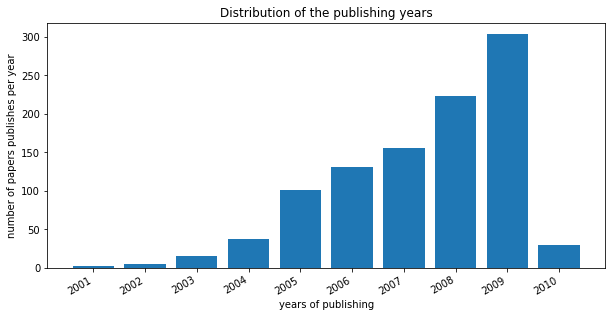

In [23]:
publish_years = []
for key in paper_dict:
    string_date = str(paper_dict[key]['publish_date'])
    if (string_date != 'nan' and string_date != ''):
        match = re.search('[0-9]{4}', string_date)
        
        if match:
            publish_year = match.group(0)
            publish_years.append(publish_year)
        else:
            print(string_date)
            
get_dict_element_by_key('journal')
# plot the distribution of the publishing years
x, y = np.unique(publish_years, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()
plot.bar(x,y)
plt.gcf().autofmt_xdate()
plt.title("Distribution of the publishing years")
plt.xlabel("years of publishing")
plt.ylabel("number of papers publishes per year")

mplcursors.cursor(hover=True)

plt.show()

## Topics

The dataset is not limited to papers specifically about COVID-19 but also covers topis about multiple other viruses. 

RNase L Mediated Protection from Virus Induced Demyelination
Barriers and supports to implementation of MDI/spacer use in nine Canadian pediatric emergency departments: a qualitative study
Application of Broad-Spectrum, Sequence-Based Pathogen Identification in an Urban Population
Functional Genetic Variants in DC-SIGNR Are Associated with Mother-to-Child Transmission of HIV-1
PRED(BALB/c): a system for the prediction of peptide binding to H2(d) molecules, a haplotype of the BALB/c mouse
"Will they just pack up and leave?" – attitudes and intended behaviour of hospital health care workers during an influenza pandemic
A flexibly shaped space-time scan statistic for disease outbreak detection and monitoring
Avian Colibacillosis and Salmonellosis: A Closer Look at Epidemiology, Pathogenesis, Diagnosis, Control and Public Health Concerns
Deletion of human metapneumovirus M2-2 increases mutation frequency and attenuates growth in hamsters
Locked nucleic acid (LNA) mediated improvements in s

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


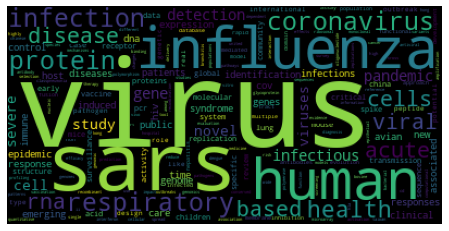

In [24]:
titles = get_dict_element_by_key('title')

titles_to_print = random.choices(titles, k=20)
print('\n'.join(titles_to_print))

topics = []
for title in titles:
  topics.extend(preprocessing(title, ['title', 'using', 'analysis']))

visualize_word_frequencies(topics)

In [0]:
titles = np.array(get_dict_element_by_key('title'))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(titles)


Setup for clustering the tfidf

In [0]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

Create K-means model

In [0]:
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

Plot the 2 most significant PCA:s

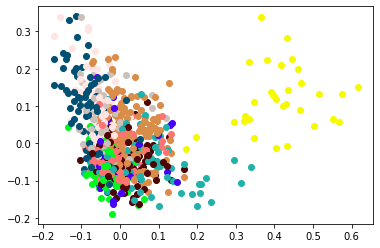

In [37]:
labels = clustering_model.fit_predict(tfidf)

X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

Plot the 2 most significant TSNE

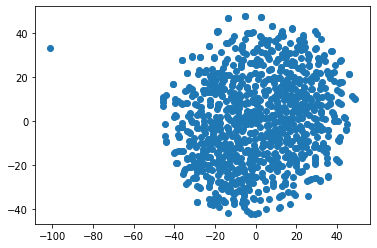

In [39]:
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

## Visualize the word frequencies

In [49]:
preprocessed_biorxiv_abstract_text = get_preprocessed_text_from_files(biorxiv_json_files, 'abstract')

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


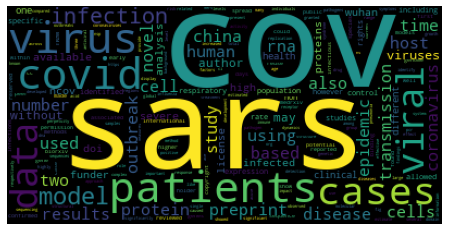

In [50]:
visualize_word_frequencies(chain(*preprocessed_biorxiv_abstract_text))

In [51]:
noncomm_biorxiv_abstract_text = get_preprocessed_text_from_files(noncomm_json_files, 'abstract')

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


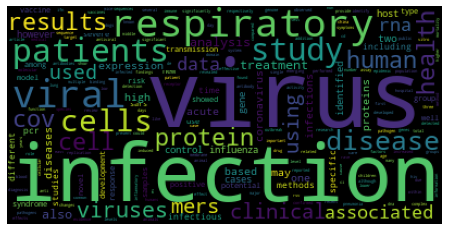

In [53]:
visualize_word_frequencies(chain(*noncomm_biorxiv_abstract_text))

# Build word2vec models for the data sets

In [60]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=biorxiv_abstracts,
    window=10,
    min_count=2,
    workers=10)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [54]:
biorxiv_model.most_similar('immunity')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wt', 0.9996515512466431),
 ('unique', 0.9996445178985596),
 ('thereby', 0.9995675086975098),
 ('region', 0.9995307326316833),
 ('peptides', 0.999481201171875),
 ('revealed', 0.9994714260101318),
 ('mirnas', 0.9994604587554932),
 ('cap', 0.9994186162948608),
 ('structures', 0.9994077086448669),
 ('recombination', 0.9993910789489746)]

In [55]:
biorxiv_model.most_similar('covid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('china', 0.9967007040977478),
 ('wuhan', 0.9963790774345398),
 ('mainland', 0.9961650371551514),
 ('fatality', 0.9947437644004822),
 ('confirmed', 0.9942633509635925),
 ('retrospectively', 0.9921365976333618),
 ('january', 0.9884114861488342),
 ('epidemic', 0.9882636070251465),
 ('patients', 0.987646222114563),
 ('qingdao', 0.987132728099823)]

In [56]:
biorxiv_model.most_similar('distancing')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('contact', 0.9986444711685181),
 ('fit', 0.9976116418838501),
 ('assuming', 0.9970937967300415),
 ('quarantine', 0.9970332980155945),
 ('counts', 0.9968964457511902),
 ('periods', 0.9967678189277649),
 ('individuals', 0.9967650175094604),
 ('traveller', 0.9966790676116943),
 ('estimating', 0.9965126514434814),
 ('projected', 0.9964739084243774)]

Do the same thing on all papers, compare results

In [0]:
# collect all abstracts from the data biorxiv data set
all_abstracts = get_preprocessed_sentences_from_files(all_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=all_abstracts,
    window=10,
    min_count=2,
    workers=10)

In [61]:
keys = ['covid', 'corona', 'immunity', 'disease', 'distancing', 'wuhan', 'china', 'herd', 'contagious',
        'vaccine', 'transmission', 'food', 'survival', 'deadly', 'cure', 'infectious', 'death']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in biorxiv_model.wv.most_similar(word, topn=15):
        words.append(similar_word)
        embeddings.append(biorxiv_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [0]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [0]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(10,7))
    
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    
    mplcursors.cursor(hover=True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show();

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

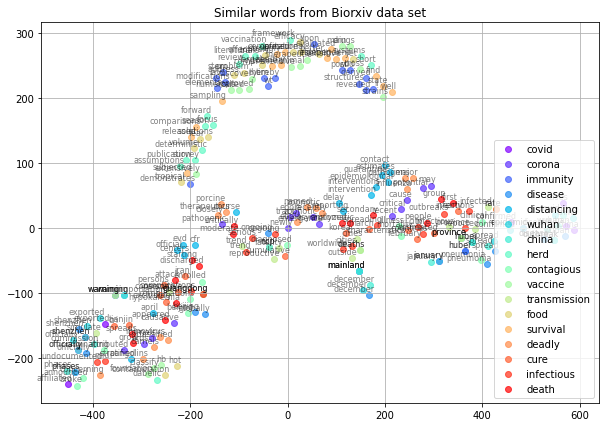

In [64]:
    
tsne_plot_similar_words('Similar words from Biorxiv data set', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

# Doc2Vec

In [66]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [68]:
# create documents
documents = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for paper_id in paper_dict:
    text = paper_dict[paper_id]['abstract']
    tags = [paper_id]
    
    sentences = nltk.sent_tokenize(str(text))

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(analyzedDocument(preprocessed_sentences, tags))

# train the model
model = Doc2Vec(documents, size=100, window=300, min_count=1, workers=4)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [69]:
# query the model
query = "What is known about transmission, incubation, and environmental stability".split()

query_vector = model.infer_vector(query)
similar_abstracts = model.docvecs.most_similar([query_vector])

for doc_tags in similar_abstracts:
    abstract = paper_dict[doc_tags[0]]['abstract']
    print(doc_tags[1])
    print(abstract)

0.9362726211547852
In the central nervous system (CNS) of man, evolutionary pressure has preserved some capability for remyelination while axonal regeneration is very limited. In contrast, two efficient programmes of regeneration exist in the adult fish CNS, neurite regrowth and remyelination. The rapidity of CNS remyelination is critical since it not only restores fast conduction of nerve impulses but also maintains axon integrity. If myelin repair fails, axons degenerate, leading to increased disability. In the human CNS demyelinating disease Multiple Sclerosis (MS), remyelination often takes place in the midst of inflammation. Here, we discuss recent studies that address the innate repair capabilities of the axon-glia unit from fish to man. We propose that expansion of this research field will help find ways to maintain or enhance spontaneous remyelination in man.
0.931230902671814
According to current models of retrovirus infection, receptor binding to the surface subunit (SU) of t

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# BM25 Index

In [70]:
# create documents
documents = []
paper_ids = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for paper_id in paper_dict:
    text = paper_dict[paper_id]['abstract']
    tags = [paper_id]
    
    sentences = nltk.sent_tokenize(str(text))

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(preprocessed_sentences)
    paper_ids.append(paper_id)

# train the model
bm25_model = BM25Okapi(documents)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [71]:
def search(search_query, num_results=10):
    preprocessed_search_query = preprocessing(search_query)
    scores = bm25_model.get_scores(preprocessed_search_query)
    top_indexes = np.argsort(scores)[::-1][0:num_results]
    return top_indexes

indexes = search('What is known about transmission, incubation, and environmental stability')
for index in indexes:
    paper_id = paper_ids[index]
    print(paper_dict[paper_id]['abstract'])

The incubation period of infectious diseases, the time from infection with a microorganism to onset of disease, is directly relevant to prevention and control. Since explicit models of the incubation period enhance our understanding of the spread of disease, previous classic studies were revisited, focusing on the modeling methods employed and paying particular attention to relatively unknown historical efforts. The earliest study on the incubation period of pandemic influenza was published in 1919, providing estimates of the incubation period of Spanish flu using the daily incidence on ships departing from several ports in Australia. Although the study explicitly dealt with an unknown time of exposure, the assumed periods of exposure, which had an equal probability of infection, were too long, and thus, likely resulted in slight underestimates of the incubation period. After the suggestion that the incubation period follows lognormal distribution, Japanese epidemiologists extended thi

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


# Implement a BERT search engine 

`Ref: https://www.kaggle.com/zoupet/covid-19-search-engine-with-bert`

The import is located here as to not infer with the other methods that's utilizing transformers

In [0]:
from sentence_transformers import SentenceTransformer

Helper functions

In [0]:
def create_df(file_list, filepath):
    contents = pd.DataFrame(columns=['text'])
    json_pattern = os.path.join(filepath, '*.json')
    file_list = glob.glob(json_pattern)
    for file in file_list:
        with open(file) as json_file:
            data = json_file.read()
        
        obj = json.loads(data)
        if len(obj['abstract']) > 0:
            content = obj['abstract'][0]['text']
            contents = contents.append({'text': content}, ignore_index=True)
    return contents

def filter_df(df):
    filtered_list_visualization = []
    filtered_list = []
    for i in range(len(df)):
        filtered_list.append(simple_preprocess(df.text.values[i]))
        for w in simple_preprocess(df.text.values[i]):
            if w in stopwords.words('english') or len(w) < 2 or w.isnumeric():
                continue
        filtered_list_visualization.append(w)
    return filtered_list, filtered_list_visualization

In [0]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [0]:
question_embedding = model.encode(['What is known about transmission, incubation, and environmental stability?'])

queries = [       "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                  "How long is the incubation period for the virus?",
                  "Can the virus be transmitted asymptomatically or during the incubation period?",
                  "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?"
              ]
query_embeddings = model.encode(queries)

The number of documents to include affects the results greatly (but also the running time ;))

In [0]:
df_noncomm = create_df(noncomm_json_files, filepath_noncomm)

In [0]:
abstract_embeddings = model.encode(df_noncomm.text.values)

# Implement a BERT summarizer

In [28]:
from summarizer import Summarizer
summary_model = Summarizer()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 176 from C header, got 216 from PyObject
  return f(*args, **kwds)


Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity and summarize their contents

In [49]:
closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        result = summary_model(df_noncomm['text'][idx])
        full = ''.join(result)
        print(df_noncomm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")
        print("\nSummary of the paper containing the sentence: ", full, "\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
To assess the effects of hepatitis B virus (HBV) on the expression of host α-1,2-mannosidases and determine the underlying mechanisms. 
(Score: 0.7361) 


Summary of the paper containing the sentence:  To assess the effects of hepatitis B virus (HBV) on the expression of host α-1,2-mannosidases and determine the underlying mechanisms. 

Ebolaviruses constitute a public health threat, particularly in Central and Western Africa. Host cell factors required for spread of ebolaviruses may serve as targets for antiviral intervention. Lectins, TAM receptor tyrosine kinases (Tyro3, Axl, Mer), T cell immunoglobulin and mucin domain (TIM) proteins, integrins, and Niemann-Pick C1 (NPC1) have been reported to promote entry of ebolaviruses into certain cellular systems. However, the factors used by ebolaviruses to invade macrophages, major viral targets, ar

Another BERT pretrained Q&A

In [0]:
import torch
from transformers import BertTokenizer
from transformers import BertForQuestionAnswering

In [0]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

BERT_SQUAD = 'bert-large-uncased-whole-word-masking-finetuned-squad'

model = BertForQuestionAnswering.from_pretrained(BERT_SQUAD)
tokenizer = BertTokenizer.from_pretrained(BERT_SQUAD)

model = model.to(torch_device)

In [0]:
question, text = "Can the virus be transmitted asymptomatically or during the incubation period?", df_noncomm['text'][0]

input_ids = tokenizer.encode(question, text)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

print(answer)